In [1]:
!pip install "/kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl"

Processing /kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl


In [2]:
import sys
sys.path.append("/kaggle/input/pip-install-textstat-mit/package")
import textstat

In [3]:
import sys
sys.path.append("/kaggle/input/pip-install-autocorrect-mit/package")
import autocorrect

In [4]:
# feedback feature

In [5]:
import pandas as pd
import numpy as np
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import DataCollatorWithPadding
%env TOKENIZERS_PARALLELISM=True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

import textstat

tokenizers.__version__: 0.13.3
transformers.__version__: 4.30.2
env: TOKENIZERS_PARALLELISM=True
cuda


In [6]:
class CFG1:
    model = "microsoft/deberta-v3-base"
    path = "../input/0911-deberta-v3-base/"
    base = "../input/fb3models/microsoft-deberta-v3-base/"
    config_path = base + "config/config.json"
    tokenizer = AutoTokenizer.from_pretrained(base + 'tokenizer/')
    gradient_checkpointing=False
    batch_size=24
    target_cols=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    seed=42
    n_fold=10
    trn_fold=list(range(n_fold))
    num_workers=8
    weight = 1.0
    
CFG_list = [CFG1]

In [7]:
def compute_mcrmse(eval_pred):
    """
    Calculates mean columnwise root mean squared error
    https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview/evaluation
    """
    preds, labels = eval_pred

    col_rmse = np.sqrt(np.mean((preds - labels) ** 2, axis=0))
    mcrmse = np.mean(col_rmse)

    return {
        "content_rmse": col_rmse[0],
        "wording_rmse": col_rmse[1],
        "mcrmse": mcrmse,
    }

In [8]:
# FROM OLD 
# ====================================================
# Utils
# ====================================================
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores

def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores

def get_logger(filename='inference'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# ====================================================
# oof
# ====================================================
for CFG in CFG_list:
    oof_df = pd.read_pickle(CFG.path+'oof_df.pkl')
    labels = oof_df[CFG.target_cols].values
    preds = oof_df[[f"pred_{c}" for c in CFG.target_cols]].values
    score, scores = get_score(labels, preds)
    LOGGER.info(f'Model: {CFG.model} Score: {score:<.4f}  Scores: {scores}')
    
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        #max_length=CFG.max_len,
        #pad_to_max_length=True,
        #truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['full_text'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        return inputs

# new for CL
class CommonlitDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        return inputs
    
# ====================================================
# Model
# ====================================================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim = 1)
        return max_embeddings
    
class MinPooling(nn.Module):
    def __init__(self):
        super(MinPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = 1e-4
        min_embeddings, _ = torch.min(embeddings, dim = 1)
        return min_embeddings
        

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = AutoConfig.from_pretrained(config_path, output_hidden_states=True)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()
        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, 6)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(feature)
        return output
    
# ====================================================
# inference
# ====================================================
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in test_loader:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

Model: microsoft/deberta-v3-base Score: 0.4595  Scores: [0.4933251819697969, 0.4502769020486089, 0.4195917881022107, 0.4616825211894006, 0.479171494341016, 0.4531265111349054]


In [9]:
prompts_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")
summaries_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")
sample_submission = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv")
test = summaries_test.merge(prompts_test, how="left", on="prompt_id")

Let's create some features using text statistics and use classic ML algorithm

In [10]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('/kaggle/input/sentence-transformers/minilm-l6-v2/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('/kaggle/input/sentence-transformers/minilm-l6-v2/all-MiniLM-L6-v2')
MEMORY = {}

def get_emb(sentences):
    if sentences in MEMORY:
        return MEMORY[sentences]
    # Tokenize sentences
    encoded_input = tokenizer([sentences], padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)[0].detach().cpu().numpy()
    MEMORY[sentences] = sentence_embeddings
    
    return sentence_embeddings

In [11]:
def get_feedback_feat(data):
    for _idx, CFG in enumerate(CFG_list):
        dataset = CommonlitDataset(CFG, data)
        loader = DataLoader(dataset,
                            batch_size=CFG.batch_size,
                            shuffle=False,
                            collate_fn=DataCollatorWithPadding(tokenizer=CFG.tokenizer, padding='longest'),
                            num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

        predictions = []
        for fold in CFG.trn_fold:
            print('='*10, f'started fold {fold}', '='*10)
            model = CustomModel(CFG, config_path=CFG.config_path, pretrained=False)
            state = torch.load(CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth",
                               map_location=torch.device('cpu'))
            model.load_state_dict(state['model'])
            prediction = inference_fn(loader, model, device)
            predictions.append(prediction)
            torch.cuda.empty_cache()
        predictions = np.mean(predictions, axis=0)
        data[CFG.target_cols] = predictions
        torch.cuda.empty_cache() 
        return data

In [12]:
from tqdm.notebook import tqdm
tqdm.pandas()
test_fe = get_feedback_feat(test)

========== started fold 0 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


========== started fold 1 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


========== started fold 2 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


========== started fold 3 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


========== started fold 4 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


========== started fold 5 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


========== started fold 6 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


========== started fold 7 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


========== started fold 8 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


========== started fold 9 ==========


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [13]:
#deberta feature

In [14]:
from typing import List
import logging
import shutil
import json
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset,load_dataset, load_from_disk
from transformers import TrainingArguments, Trainer
from datasets import load_metric, disable_progress_bar
from sklearn.metrics import mean_squared_error
import torch
from sklearn.model_selection import KFold, GroupKFold
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
import spacy
import re
from autocorrect import Speller
from spellchecker import SpellChecker
import lightgbm as lgb

warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
disable_progress_bar()
tqdm.pandas()

In [15]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed=42)


In [16]:
class CFG:
    model_name="debertav3base"
    learning_rate=1.5e-5
    weight_decay=0.02
    hidden_dropout_prob=0.007
    attention_probs_dropout_prob=0.007
    num_train_epochs=5
    n_splits=4
    batch_size=12
    random_seed=42
    save_steps=100
    max_length=512

In [17]:
class Preprocessor:
    def __init__(self, 
                model_name: str,
                ) -> None:  
        self.tokenizer = AutoTokenizer.from_pretrained(f"/kaggle/input/{model_name}")
        self.twd = TreebankWordDetokenizer()
        self.STOP_WORDS = set(stopwords.words('english'))
        
        self.spacy_ner_model = spacy.load('en_core_web_sm',)
        self.speller = Speller(lang='en')
        self.spellchecker = SpellChecker() 
        
    def word_overlap_count(self, row): 
        """ intersection(prompt_text, text) """        
        def check_is_stop_word(word):
            return word in self.STOP_WORDS
        
        prompt_words = row['prompt_tokens']
        summary_words = row['summary_tokens']
        if self.STOP_WORDS:
            prompt_words = list(filter(check_is_stop_word, prompt_words))
            summary_words = list(filter(check_is_stop_word, summary_words))
        return len(set(prompt_words).intersection(set(summary_words)))
            
    def ngrams(self, token, n): 
        # Use the zip function to help us generate n-grams
        # Concatentate the tokens into ngrams and return
        ngrams = zip(*[token[i:] for i in range(n)])
        return [" ".join(ngram) for ngram in ngrams]

    def ngram_co_occurrence(self, row, n: int) -> int: 
        # Tokenize the original text and summary into words
        original_tokens = row['prompt_tokens']
        summary_tokens = row['summary_tokens']

        # Generate n-grams for the original text and summary
        original_ngrams = set(self.ngrams(original_tokens, n))
        summary_ngrams = set(self.ngrams(summary_tokens, n))

        # Calculate the number of common n-grams
        common_ngrams = original_ngrams.intersection(summary_ngrams)
        return len(common_ngrams)
    
    def ner_overlap_count(self, row, mode:str): 
        model = self.spacy_ner_model
        def clean_ners(ner_list):
            return set([(ner[0].lower(), ner[1]) for ner in ner_list])
        prompt = model(row['prompt_text'])
        summary = model(row['text'])

        if "spacy" in str(model):
            prompt_ner = set([(token.text, token.label_) for token in prompt.ents])
            summary_ner = set([(token.text, token.label_) for token in summary.ents])
        elif "stanza" in str(model):
            prompt_ner = set([(token.text, token.type) for token in prompt.ents])
            summary_ner = set([(token.text, token.type) for token in summary.ents])
        else:
            raise Exception("Model not supported")

        prompt_ner = clean_ners(prompt_ner)
        summary_ner = clean_ners(summary_ner)

        intersecting_ners = prompt_ner.intersection(summary_ner)
        
        ner_dict = dict(Counter([ner[1] for ner in intersecting_ners]))
        
        if mode == "train":
            return ner_dict
        elif mode == "test":
            return {key: ner_dict.get(key) for key in self.ner_keys}

    
    def quotes_count(self, row): 
        summary = row['text']
        text = row['prompt_text']
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        if len(quotes_from_summary)>0:
            return [quote in text for quote in quotes_from_summary].count(True)
        else:
            return 0

    def spelling(self, text): 
        
        wordlist=text.split()
        amount_miss = len(list(self.spellchecker.unknown(wordlist)))

        return amount_miss
    
    def add_spelling_dictionary(self, tokens: List[str]) -> List[str]: 
        """dictionary update for pyspell checker and autocorrect"""
        self.spellchecker.word_frequency.load_words(tokens)
        self.speller.nlp_data.update({token:1000 for token in tokens})
    
    def run(self, 
            prompts: pd.DataFrame,
            summaries:pd.DataFrame,
            mode:str
        ) -> pd.DataFrame: 
        
        # before merge preprocess
        prompts["prompt_length"] = prompts["prompt_text"].apply(
            lambda x: len(word_tokenize(x))
        )
        prompts["prompt_tokens"] = prompts["prompt_text"].apply(
            lambda x: word_tokenize(x)
        )

        summaries["summary_length"] = summaries["text"].apply(
            lambda x: len(word_tokenize(x))
        )
        summaries["summary_tokens"] = summaries["text"].apply(
            lambda x: word_tokenize(x)
        )
        
        # Add prompt tokens into spelling checker dictionary
        prompts["prompt_tokens"].apply(
            lambda x: self.add_spelling_dictionary(x)
        )
        
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        # fix misspelling
        summaries["fixed_summary_text"] = summaries["text"].progress_apply(
            lambda x: self.speller(x.lower())
        )
        
        # count misspelling
        summaries["splling_err_num"] = summaries["text"].progress_apply(self.spelling)
        
        # merge prompts and summaries
        input_df = summaries.merge(prompts, how="left", on="prompt_id")

        # after merge preprocess
        input_df['length_ratio'] = input_df['summary_length'] / input_df['prompt_length']
        
        input_df['word_overlap_count'] = input_df.progress_apply(self.word_overlap_count, axis=1)
        input_df['bigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence,args=(2,), axis=1 
        )
        input_df['bigram_overlap_ratio'] = input_df['bigram_overlap_count'] / (input_df['summary_length'] - 1)
        
        input_df['trigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence, args=(3,), axis=1
        )
        input_df['trigram_overlap_ratio'] = input_df['trigram_overlap_count'] / (input_df['summary_length'] - 2)
        
        input_df['quotes_count'] = input_df.progress_apply(self.quotes_count, axis=1)
        
        return input_df.drop(columns=["summary_tokens", "prompt_tokens"])
    
preprocessor = Preprocessor(model_name=CFG.model_name)

In [18]:
test = preprocessor.run(prompts_test, summaries_test, mode="test")

100%|██████████| 4/4 [00:00<00:00, 2458.20it/s]


In [19]:
test["prompt_text"]=test["prompt_text"].str.lower()
test["prompt_title"]=test["prompt_title"].str.lower()
test["prompt_question"]=test["prompt_question"].str.lower()

In [20]:
#Model Function Definition
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

def compute_mcrmse(eval_pred):
    """
    Calculates mean columnwise root mean squared error
    https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview/evaluation
    """
    preds, labels = eval_pred

    col_rmse = np.sqrt(np.mean((preds - labels) ** 2, axis=0))
    mcrmse = np.mean(col_rmse)

    return {
        "content_rmse": col_rmse[0],
        "wording_rmse": col_rmse[1],
        "mcrmse": mcrmse,
    }

def compt_score(content_true, content_pred, wording_true, wording_pred):
    content_score = mean_squared_error(content_true, content_pred)**(1/2)
    wording_score = mean_squared_error(wording_true, wording_pred)**(1/2)
    
    return (content_score + wording_score)/2

In [21]:
class ContentScoreRegressor:
    def __init__(self, 
                model_name: str,
                model_dir: str,
                target: str,
                hidden_dropout_prob: float,
                attention_probs_dropout_prob: float,
                max_length: int,
                ):
        self.inputs = ["prompt_text", "prompt_title", "prompt_question", "fixed_summary_text"]
        self.input_col = "input"
        
        self.text_cols = [self.input_col] 
        self.target = target
        self.target_cols = [target]

        self.model_name = model_name
        self.model_dir = model_dir
        self.max_length = max_length
        
        self.tokenizer = AutoTokenizer.from_pretrained(f"/kaggle/input/{model_name}")
        self.model_config = AutoConfig.from_pretrained(f"/kaggle/input/{model_name}")
        
        self.model_config.update({
            "hidden_dropout_prob": hidden_dropout_prob,
            "attention_probs_dropout_prob": attention_probs_dropout_prob,
            "num_labels": 1,
            "problem_type": "regression",
        })
        
        seed_everything(seed=42)

        self.data_collator = DataCollatorWithPadding(
            tokenizer=self.tokenizer
        )


    def tokenize_function(self, examples: pd.DataFrame):
        labels = [examples[self.target]]
        tokenized = self.tokenizer(examples[self.input_col],
                         padding=False,
                         truncation=True,
                         max_length=self.max_length)
        return {
            **tokenized,
            "labels": labels,
        }
    
    def tokenize_function_test(self, examples: pd.DataFrame):
        tokenized = self.tokenizer(examples[self.input_col],
                         padding=False,
                         truncation=True,
                         max_length=self.max_length)
        return tokenized
        
    def train(self, 
            fold: int,
            train_df: pd.DataFrame,
            valid_df: pd.DataFrame,
            batch_size: int,
            learning_rate: float,
            weight_decay: float,
            num_train_epochs: float,
            save_steps: int,
        ) -> None:
        """fine-tuning"""
        
        sep = self.tokenizer.sep_token
        train_df[self.input_col] = (
                    train_df["prompt_title"] + sep 
                    + train_df["prompt_question"] + sep 
                    + train_df["fixed_summary_text"]
                  )

        valid_df[self.input_col] = (
                    valid_df["prompt_title"] + sep 
                    + valid_df["prompt_question"] + sep 
                    + valid_df["fixed_summary_text"]
                  )
        
        train_df = train_df[[self.input_col] + self.target_cols]
        valid_df = valid_df[[self.input_col] + self.target_cols]
        
        model_content = AutoModelForSequenceClassification.from_pretrained(
            f"/kaggle/input/{self.model_name}", 
            config=self.model_config
        )

        train_dataset = Dataset.from_pandas(train_df, preserve_index=False) 
        val_dataset = Dataset.from_pandas(valid_df, preserve_index=False) 
    
        train_tokenized_datasets = train_dataset.map(self.tokenize_function, batched=False)
        val_tokenized_datasets = val_dataset.map(self.tokenize_function, batched=False)

        # eg. "bert/fold_0/"
        model_fold_dir = os.path.join(self.model_dir, str(fold)) 
        
        training_args = TrainingArguments(
            output_dir=model_fold_dir,
            load_best_model_at_end=True, # select best model
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=8,
            num_train_epochs=num_train_epochs,
            weight_decay=weight_decay,
            report_to='none',
            greater_is_better=False,
            save_strategy="steps",
            evaluation_strategy="steps",
            eval_steps=save_steps,
            save_steps=save_steps,
            metric_for_best_model="rmse",
            save_total_limit=1
        )

        trainer = Trainer(
            model=model_content,
            args=training_args,
            train_dataset=train_tokenized_datasets,
            eval_dataset=val_tokenized_datasets,
            tokenizer=self.tokenizer,
            compute_metrics=compute_metrics,
            data_collator=self.data_collator
        )

        trainer.train()
        
        model_content.save_pretrained(self.model_dir)
        self.tokenizer.save_pretrained(self.model_dir)

        
    def predict(self, 
                test_df: pd.DataFrame,
                fold: int,
               ):
        """predict content score"""
        
        sep = self.tokenizer.sep_token
        in_text = (
                    test_df["prompt_title"] + sep 
                    + test_df["prompt_question"] + sep 
                    + test_df["fixed_summary_text"]
                  )
        test_df[self.input_col] = in_text

        test_ = test_df[[self.input_col]]
    
        test_dataset = Dataset.from_pandas(test_, preserve_index=False) 
        test_tokenized_dataset = test_dataset.map(self.tokenize_function_test, batched=False)

        model_content = AutoModelForSequenceClassification.from_pretrained(f"{self.model_dir}")
        model_content.eval()
        
        # e.g. "bert/fold_0/"
        model_fold_dir = os.path.join(self.model_dir, str(fold)) 

        test_args = TrainingArguments(
            output_dir=model_fold_dir,
            do_train = False,
            do_predict = True,
            per_device_eval_batch_size = 4,   
            dataloader_drop_last = False,
        )

        # init trainer
        infer_content = Trainer(
                      model = model_content, 
                      tokenizer=self.tokenizer,
                      data_collator=self.data_collator,
                      args = test_args)

        preds = infer_content.predict(test_tokenized_dataset)[0]

        return preds

In [22]:
def train_by_fold(
        train_df: pd.DataFrame,
        model_name: str,
        target:str,
        save_each_model: bool,
        n_splits: int,
        batch_size: int,
        learning_rate: int,
        hidden_dropout_prob: float,
        attention_probs_dropout_prob: float,
        weight_decay: float,
        num_train_epochs: int,
        save_steps: int,
        max_length:int
    ):

    # delete old model files
    if os.path.exists(model_name):
        shutil.rmtree(model_name)
    
    os.mkdir(model_name)
        
    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        train_data = train_df[train_df["fold"] != fold]
        valid_data = train_df[train_df["fold"] == fold]
        
        if save_each_model == True:
            model_dir =  f"{target}/{model_name}/fold_{fold}"
        else: 
            model_dir =  f"{model_name}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir, 
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        csr.train(
            fold=fold,
            train_df=train_data,
            valid_df=valid_data, 
            batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            num_train_epochs=num_train_epochs,
            save_steps=save_steps,
        )

def validate(
    train_df: pd.DataFrame,
    target:str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length : int
    ) -> pd.DataFrame:
    """predict oof data"""
    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        valid_data = train_df[train_df["fold"] == fold]
        
        if save_each_model == True:
            model_dir =  f"{target}/{model_name}/fold_{fold}"
        else: 
            model_dir =  f"{model_name}/fold_{fold}"
        
        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir,
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        pred = csr.predict(
            test_df=valid_data, 
            fold=fold
        )
        
        train_df.loc[valid_data.index, f"{target}_pred"] = pred

    return train_df

In [23]:
#content model

In [24]:
def predict(
    test_df: pd.DataFrame,
    target:str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length : int
    ):
    """predict using mean folds"""

    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        if save_each_model == True:
            model_dir =  f"/kaggle/input/deberta-content-training-fix-autocorrect-lower/{target}/{model_name}/fold_{fold}"
        else: 
            model_dir =  f"{model_name}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir, 
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        pred = csr.predict(
            test_df=test_df, 
            fold=fold
        )
        
        test_df[f"{target}_pred_{fold}"] = pred
    
    test_df[f"{target}_pred"] = test_df[[f"{target}_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)

    return test_df

In [25]:
for target in ["content"]:
    test_content = predict(
        test,
        target=target,
        save_each_model=True,
        model_name=CFG.model_name,
        hidden_dropout_prob=CFG.hidden_dropout_prob,
        attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
        max_length=CFG.max_length
    )

fold 0:


fold 1:


fold 2:


fold 3:


In [26]:
test_content

,student_id,prompt_id,text,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,...,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count,input,content_pred_0,content_pred_1,content_pred_2,content_pred_3,content_pred
0,000000ffffff,abc123,Example text 1,3,example text 1,0,summarize...,example title 1,heading\ntext...,3,...,0.0,0,0.0,0,example title 1[SEP]summarize...[SEP]example t...,-1.510672,-1.746204,-1.461809,-1.517933,-1.559154
1,111111eeeeee,def789,Example text 2,3,example text 2,0,summarize...,example title 2,heading\ntext...,3,...,0.0,0,0.0,0,example title 2[SEP]summarize...[SEP]example t...,-1.513382,-1.744912,-1.464548,-1.511430,-1.558568
2,222222cccccc,abc123,Example text 3,3,example text 3,0,summarize...,example title 1,heading\ntext...,3,...,0.0,0,0.0,0,example title 1[SEP]summarize...[SEP]example t...,-1.512837,-1.739753,-1.469512,-1.518265,-1.560092
3,333333dddddd,def789,Example text 4,3,example text 4,0,summarize...,example title 2,heading\ntext...,3,...,0.0,0,0.0,0,example title 2[SEP]summarize...[SEP]example t...,-1.517421,-1.744104,-1.476171,-1.527631,-1.566332


In [27]:
test_content=test_content[['student_id', 'prompt_id','summary_length',
                           'splling_err_num','prompt_length','length_ratio',
                           'word_overlap_count','bigram_overlap_count','bigram_overlap_ratio',
                           'trigram_overlap_count','trigram_overlap_ratio','quotes_count','content_pred']]

In [28]:
test_content=test_content.merge(test_fe,how='inner',on=['student_id', 'prompt_id'])

In [29]:
# wording model

In [30]:
def predict(
    test_df: pd.DataFrame,
    target:str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length : int
    ):
    """predict using mean folds"""

    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        if save_each_model == True:
            model_dir =  f"/kaggle/input/deberta-wording-training-fix-autocorrect-lower/{target}/{model_name}/fold_{fold}"
        else: 
            model_dir =  f"{model_name}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir, 
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        pred = csr.predict(
            test_df=test_df, 
            fold=fold
        )
        
        test_df[f"{target}_pred_{fold}"] = pred
    
    test_df[f"{target}_pred"] = test_df[[f"{target}_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)

    return test_df

In [31]:
for target in ["wording"]:
    test_wording = predict(
        test,
        target=target,
        save_each_model=True,
        model_name=CFG.model_name,
        hidden_dropout_prob=CFG.hidden_dropout_prob,
        attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
        max_length=CFG.max_length
    )

fold 0:


fold 1:


fold 2:


fold 3:


In [32]:
test_wording=test_wording[['student_id', 'prompt_id','wording_pred']]

In [33]:
test_wording

,student_id,prompt_id,wording_pred
0,000000ffffff,abc123,-1.380788
1,111111eeeeee,def789,-1.380234
2,222222cccccc,abc123,-1.386539
3,333333dddddd,def789,-1.396522


In [34]:
test=test_content.merge(test_wording,how='inner',on=['student_id', 'prompt_id'])

In [35]:
# statistics

In [36]:
from sklearn.metrics import r2_score
import os
import glob
from tqdm import tqdm
from joblib import Parallel, delayed

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna
from optuna.samplers import TPESampler
import lightgbm as lgb
from sklearn.metrics import mean_squared_error


import string
import pickle
import operator
from textblob import TextBlob

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
tqdm.pandas()

In [37]:
# Load model from HuggingFace Hub
tokenizer_sb = AutoTokenizer.from_pretrained('/kaggle/input/sentence-transformers/sentence-transformers/minil2-l12-v2/paraphrase-multilingual-MiniLM-L12-v2')
model_sb = AutoModel.from_pretrained('/kaggle/input/sentence-transformers/sentence-transformers/minil2-l12-v2/paraphrase-multilingual-MiniLM-L12-v2').cuda()
MEMORY_SB = {}

tokenizer_qa = AutoTokenizer.from_pretrained('/kaggle/input/multi-qa-mpnet-base-dot-v1/multi-qa-mpnet-base-dot-v1')
model_qa = AutoModel.from_pretrained('/kaggle/input/multi-qa-mpnet-base-dot-v1/multi-qa-mpnet-base-dot-v1').cuda()
MEMORY_QA = {}

tokenizer_ch = AutoTokenizer.from_pretrained('/kaggle/input/bert-cohesion/bert_cohesion')
model_ch = AutoModelForSequenceClassification.from_pretrained('/kaggle/input/bert-cohesion/bert_cohesion', num_labels=9).cuda()

tokenizer_rw = AutoTokenizer.from_pretrained('/kaggle/input/reward-model-deberta-v3-large-v2-wch/reward-model-deberta-v3-large-v2-wch')
model_rw = AutoModelForSequenceClassification.from_pretrained('/kaggle/input/reward-model-deberta-v3-large-v2-wch/reward-model-deberta-v3-large-v2-wch',
                                                              num_labels=1).cuda()

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def cls_pooling(model_output):
    return model_output.last_hidden_state[:,0]

def get_emb_sb(sentences):
    if sentences in MEMORY_SB:
        return MEMORY_SB[sentences]
    # Tokenize sentences
    encoded_input = tokenizer_sb([sentences], padding=True, truncation=True, return_tensors='pt')
    encoded_input = {k:v.cuda() for k, v in encoded_input.items()}

    # Compute token embeddings
    with torch.no_grad():
        model_output = model_sb(**encoded_input)

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)[0].detach().cpu().numpy()
    MEMORY_SB[sentences] = sentence_embeddings
    
    return sentence_embeddings

def get_emb_qa(sentences):
    if sentences in MEMORY_QA:
        return MEMORY_QA[sentences]
    # Tokenize sentences
    encoded_input = tokenizer_qa([sentences], padding=True, truncation=True, return_tensors='pt')
    encoded_input = {k:v.cuda() for k, v in encoded_input.items()}
    
    # Compute token embeddings
    with torch.no_grad():
        model_output = model_qa(**encoded_input)

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)[0].detach().cpu().numpy()
    MEMORY_QA[sentences] = sentence_embeddings
    
    return sentence_embeddings

def get_ch_label(sentences):
    encoded_input = tokenizer_ch([sentences], padding=True, truncation=True, return_tensors='pt')
    encoded_input = {k:v.cuda() for k, v in encoded_input.items()}
    
    with torch.no_grad():
        model_output = model_ch(**encoded_input)["logits"]
    
#     print(model_output)
    label = torch.argmax(model_output, dim=1)[0].detach().cpu().numpy()
    
    return label

def get_rw(question, answer):
    encoded_input = tokenizer_rw(question, answer, padding=True, truncation=True, return_tensors='pt')
    encoded_input = {k:v.cuda() for k, v in encoded_input.items()}
    
    with torch.no_grad():
        model_output = model_rw(**encoded_input)["logits"]
    
    return torch.sigmoid(model_output)[0].cpu().detach().numpy()[0]


In [38]:
def pos_count(sent):
    nn_count = 0   #Noun
    pr_count = 0   #Pronoun
    vb_count = 0   #Verb
    jj_count = 0   #Adjective
    uh_count = 0   #Interjection
    cd_count = 0   #Numerics
    
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)

    for token in sent:
        if token[1] in ['NN','NNP','NNS']:
            nn_count += 1

        if token[1] in ['PRP','PRP$']:
            pr_count += 1

        if token[1] in ['VB','VBD','VBG','VBN','VBP','VBZ']:
            vb_count += 1

        if token[1] in ['JJ','JJR','JJS']:
            jj_count += 1

        if token[1] in ['UH']:
            uh_count += 1

        if token[1] in ['CD']:
            cd_count += 1
    
    return pd.Series([nn_count, pr_count, vb_count, jj_count, uh_count, cd_count])

In [39]:
test["num_words"] = test["text"].progress_apply(lambda x: len(str(x).split()))
test["num_unique_words"] = test["text"].progress_apply(lambda x: len(set(str(x).split())))
test["num_chars"] = test["text"].progress_apply(lambda x: len(str(x)))
test["num_stopwords"] = test["text"].progress_apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))
test["num_punctuations"] =test['text'].progress_apply(lambda x: len([c for c in str(x) if c in list(string.punctuation)]))
test["num_words_upper"] = test["text"].progress_apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_title"] = test["text"].progress_apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["mean_word_len"] = test["text"].progress_apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_num_unique_words"] = test["text"].progress_apply(lambda x: np.mean([len(set(e.split())) for e in x.split('.')]))
test["num_paragraphs"] = test["text"].progress_apply(lambda x: len(x.split('\n\n')))
test["num_slash"] = test["text"].progress_apply(lambda x: len(x.split('\n')))
test["syntax_count"] = test["text"].progress_apply(lambda x: x.count(",") + x.count("-") + x.count(";") + x.count(":"))
test["num_sentences"] = test["text"].progress_apply(lambda x: len(str(x).split('.')))
test["polarity"] = test['text'].progress_apply(lambda x: TextBlob(x).sentiment[0])
test["subjectivity"] = test['text'].progress_apply(lambda x: TextBlob(x).sentiment[1])
test[['nn_count','pr_count','vb_count','jj_count','uh_count','cd_count']] = test['text'].progress_apply(pos_count)

100%|██████████| 4/4 [00:00<00:00, 31.50it/s]


In [40]:
def get_stat_features(df, text_col="text"):
    df['diff_emb_sb'] = df.progress_apply(lambda x: np.sum(get_emb_sb(x["text"])*get_emb_sb(x["prompt_text"])), axis=1)
    df['diff_emb_qa'] = df.progress_apply(lambda x: np.sum(get_emb_qa(x["text"])*get_emb_qa(x["prompt_question"])), axis=1)
    df['ch'] = df.progress_apply(lambda x: get_ch_label(x["text"]), axis=1)
    df['rw'] = df.progress_apply(lambda x: get_rw(x["prompt_question"], x["text"]), axis=1)

    df['automated_readability_index'] = df[text_col].progress_apply(lambda x: textstat.automated_readability_index(x))
    df['coleman_liau_index'] = df[text_col].progress_apply(lambda x: textstat.coleman_liau_index(x))
    df['smog_index'] = df[text_col].progress_apply(lambda x: textstat.smog_index(x))
    df['flesch_reading_ease'] = df[text_col].progress_apply(lambda x: textstat.flesch_reading_ease(x))
    df['flesch_kincaid_grade'] = df[text_col].progress_apply(lambda x: textstat.flesch_kincaid_grade(x))
    df['dale_chall_readability_score'] = df[text_col].progress_apply(lambda x: textstat.dale_chall_readability_score(x))
    df['linsear_write_formula'] = df[text_col].progress_apply(lambda x: textstat.linsear_write_formula(x))
    df['gunning_fog'] = df[text_col].progress_apply(lambda x: textstat.gunning_fog(x))
    df['text_standard_float'] = df[text_col].progress_apply(lambda x: textstat.text_standard(x, float_output=True))
    df['spache_readability'] = df[text_col].progress_apply(lambda x: textstat.spache_readability(x))
    df['rix'] = df[text_col].progress_apply(lambda x: textstat.rix(x))
    df['lix'] = df[text_col].progress_apply(lambda x: textstat.lix(x))

    return df

In [41]:
test= get_stat_features(test)

100%|██████████| 4/4 [00:00<00:00, 7397.36it/s]


In [42]:
import nltk
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from nltk import ne_chunk, word_tokenize, pos_tag
import dask.dataframe as dd
from dask.multiprocessing import get

In [43]:
# Additional features

def calculate_pos_ratios(text):
    pos_tags = pos_tag(nltk.word_tokenize(text))
    pos_counts = Counter(tag for word, tag in pos_tags)
    total_words = len(pos_tags)
    ratios = {tag: count / total_words for tag, count in pos_counts.items()}
    return ratios

sid = SentimentIntensityAnalyzer()
def calculate_sentiment_scores(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores
 

def calculate_punctuation_ratios(text):
    total_chars = len(text)
    punctuation_counts = Counter(char for char in text if char in '.,!?;:"()[]{}')
    ratios = {char: count / total_chars for char, count in punctuation_counts.items()}
    return ratios


# keyword density
def calculate_keyword_density(row):
    keywords = set(row['prompt_text'].split())
    text_words = row['text'].split()
    keyword_count = sum(1 for word in text_words if word in keywords)
    return keyword_count / len(text_words)


# Function to calculate sentiment scores for prompt text
sid = SentimentIntensityAnalyzer()
def calculate_sentiment_scores_prompt(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

In [44]:
drop_col=['pos_ratios','sentiment_scores','punctuation_ratios','sentiment_scores_prompt']

In [45]:
test['comma_count'] = test['text'].apply(lambda x: x.count(','))
test['semicolon_count'] = test['text'].apply(lambda x: x.count(';'))
test['exclamation_count'] = test['text'].apply(lambda x: x.count('!'))
test['question_count'] = test['text'].apply(lambda x: x.count('?'))
# Calculate POS ratios for each row
test['pos_ratios'] = test['text'].apply(calculate_pos_ratios)

# Convert the dictionary of POS ratios into a single value (mean)
test['pos_mean'] = test['pos_ratios'].apply(lambda x: np.mean(list(x.values())))
 
#Calculate sentiment scores for each row
test['sentiment_scores'] = test['text'].apply(calculate_sentiment_scores)

# Convert sentiment_scores into individual columns
sentiment_columns = pd.DataFrame(list(test['sentiment_scores']))
test= pd.concat([test, sentiment_columns], axis=1)

test['punctuation_ratios'] = test['text'].apply(calculate_punctuation_ratios)

# Convert the dictionary of punctuation ratios into a single value (sum)
test['punctuation_sum'] = test['punctuation_ratios'].apply(lambda x: np.sum(list(x.values())))

test['keyword_density'] = test.apply(calculate_keyword_density, axis=1)


# Calculate sentiment scores for prompt text
test['sentiment_scores_prompt'] = test['prompt_text'].apply(calculate_sentiment_scores_prompt)

# Convert sentiment_scores_prompt into individual columns
sentiment_columns_prompt = pd.DataFrame(list(test['sentiment_scores_prompt']))
sentiment_columns_prompt.columns = [col +'_prompt' for col in sentiment_columns_prompt.columns]

test = pd.concat([test, sentiment_columns_prompt], axis=1)

# Jaccard similarity between prompt text and text
test['jaccard_similarity'] = test.apply(lambda row: len(set(word_tokenize(row['prompt_text'])) & set(word_tokenize(row['text']))) / len(set(word_tokenize(row['prompt_text'])) | set(word_tokenize(row['text']))), axis=1)

In [46]:
test.drop(drop_col, axis=1, inplace=True)

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob

In [48]:
class Preprocessor:
    def __init__(self, 
                model_name: str,
                ) -> None:
        self.tokenizer = AutoTokenizer.from_pretrained(f"/kaggle/input/{model_name}")
        self.twd = TreebankWordDetokenizer()
        self.STOP_WORDS = set(stopwords.words('english'))
        
        self.spacy_ner_model = spacy.load('en_core_web_sm',)
        self.speller = Speller(lang='en')
        self.spellchecker = SpellChecker() 
    
        
    def calculate_text_similarity(self, row):
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform([row['prompt_text'], row['text']])
        return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2]).flatten()[0]
    
    
    def run(self, 
            prompts: pd.DataFrame,
            summaries:pd.DataFrame,
            mode:str
        ) -> pd.DataFrame:
        
        # before merge preprocess

                # before merge preprocess
        prompts["prompt_tokens"] = prompts["prompt_text"].apply(
            lambda x: word_tokenize(x)
        )

        summaries["summary_tokens"] = summaries["text"].apply(
            lambda x: word_tokenize(x)
        )
        
        input_df = summaries.merge(prompts, how="left", on="prompt_id")
        tqdm.pandas(desc="Calculating Text Similarity")
        input_df['text_similarity'] = input_df.progress_apply(self.calculate_text_similarity, axis=1)

        return input_df.drop(columns=["summary_tokens", "prompt_tokens"])
    
preprocessor = Preprocessor(model_name=CFG.model_name)

In [49]:
test_2 = preprocessor.run(prompts_test, summaries_test, mode="test")

Calculating Text Similarity: 100%|██████████| 4/4 [00:00<00:00, 146.48it/s]


In [50]:
test_2=test_2[['student_id', 'prompt_id','text_similarity']]

In [51]:
test=test.merge(test_2,how='inner',on=['student_id', 'prompt_id'])

In [52]:
test['ch']=test['ch'].astype(float)

In [53]:
test.columns

Index(['student_id', 'prompt_id', 'summary_length', 'splling_err_num',
       'prompt_length', 'length_ratio', 'word_overlap_count',
       'bigram_overlap_count', 'bigram_overlap_ratio', 'trigram_overlap_count',
       'trigram_overlap_ratio', 'quotes_count', 'content_pred', 'text',
       'prompt_question', 'prompt_title', 'prompt_text', 'cohesion', 'syntax',
       'vocabulary', 'phraseology', 'grammar', 'conventions', 'wording_pred',
       'num_words', 'num_unique_words', 'num_chars', 'num_stopwords',
       'num_punctuations', 'num_words_upper', 'num_words_title',
       'mean_word_len', 'mean_num_unique_words', 'num_paragraphs', 'num_slash',
       'syntax_count', 'num_sentences', 'polarity', 'subjectivity', 'nn_count',
       'pr_count', 'vb_count', 'jj_count', 'uh_count', 'cd_count',
       'diff_emb_sb', 'diff_emb_qa', 'ch', 'rw', 'automated_readability_index',
       'coleman_liau_index', 'smog_index', 'flesch_reading_ease',
       'flesch_kincaid_grade', 'dale_chall_readabi

In [54]:
train=pd.read_csv('/kaggle/input/train-final-fe-fixpackages-lower/train_final_fe_fixpakcages_lower.csv')

In [55]:
train.columns

Index(['student_id', 'prompt_id', 'summary_length', 'splling_err_num',
       'prompt_length', 'length_ratio', 'word_overlap_count',
       'bigram_overlap_count', 'bigram_overlap_ratio', 'trigram_overlap_count',
       'trigram_overlap_ratio', 'quotes_count', 'content_pred', 'fold', 'text',
       'content', 'wording', 'prompt_question', 'prompt_title', 'prompt_text',
       'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar',
       'conventions', 'wording_pred', 'num_words', 'num_unique_words',
       'num_chars', 'num_stopwords', 'num_punctuations', 'num_words_upper',
       'num_words_title', 'mean_word_len', 'mean_num_unique_words',
       'num_paragraphs', 'num_slash', 'syntax_count', 'num_sentences',
       'polarity', 'subjectivity', 'nn_count', 'pr_count', 'vb_count',
       'jj_count', 'uh_count', 'cd_count', 'diff_emb_sb', 'diff_emb_qa', 'ch',
       'rw', 'automated_readability_index', 'coleman_liau_index', 'smog_index',
       'flesch_reading_ease', 'flesch_kinca

In [56]:
no_features = ["student_id", "prompt_id", "prompt_question", "prompt_title", "prompt_text",'fold','fixed_summary_text','text']
target = ["content", "wording"]
fe_columns = [col for col in train.columns if col not in no_features + target]

corr = train[fe_columns + target].corr()
corr.style.background_gradient(cmap='coolwarm')

,summary_length,splling_err_num,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count,content_pred,cohesion,syntax,vocabulary,phraseology,grammar,conventions,wording_pred,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,mean_num_unique_words,num_paragraphs,num_slash,syntax_count,num_sentences,polarity,subjectivity,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,diff_emb_sb,diff_emb_qa,ch,rw,automated_readability_index,coleman_liau_index,smog_index,flesch_reading_ease,flesch_kincaid_grade,dale_chall_readability_score,linsear_write_formula,gunning_fog,text_standard_float,spache_readability,rix,lix,comma_count,semicolon_count,exclamation_count,question_count,pos_mean,neg,neu,pos,compound,punctuation_sum,keyword_density,neg_prompt,neu_prompt,pos_prompt,compound_prompt,jaccard_similarity,text_similarity,content,wording
summary_length,1.000000,0.900955,0.030706,0.940968,0.813040,0.778061,0.130289,0.689296,0.199103,0.460188,0.897930,0.769760,0.659334,0.720299,0.661381,0.557595,0.496256,0.668886,0.997188,0.982403,0.994672,0.979326,0.888061,0.157580,0.782267,0.122320,0.223653,0.004206,0.020700,0.775181,0.788657,0.002062,0.020938,0.951282,0.654686,0.951655,0.816780,0.149277,0.462702,0.766941,0.208959,0.055917,0.355376,0.080398,0.121883,0.495578,-0.044843,0.042974,-0.045479,-0.021214,0.006878,0.074617,-0.000379,0.043226,0.071589,0.770139,0.355245,0.185730,0.121107,-0.664021,-0.098078,0.102567,-0.057353,0.029885,0.227665,0.102272,-0.121509,0.129606,-0.113521,0.075551,0.848759,0.649977,0.790034,0.526730
splling_err_num,0.900955,1.000000,-0.054981,0.885750,0.654944,0.729154,0.153787,0.650443,0.215871,0.468423,0.800866,0.655596,0.537783,0.592267,0.522660,0.420623,0.346512,0.551628,0.875466,0.888509,0.895922,0.832016,0.935500,0.182807,0.781887,0.270944,0.068078,0.010852,0.028182,0.833574,0.812023,0.053590,0.015943,0.902698,0.490221,0.820269,0.741134,0.174318,0.421747,0.770090,0.189401,0.048291,0.401417,0.000198,0.201524,0.465670,-0.023442,-0.048546,0.064387,-0.124351,-0.078574,0.028138,-0.070856,-0.005561,0.024407,0.841744,0.334327,0.205073,0.158271,-0.596563,-0.096628,0.084811,-0.023745,0.064145,0.440928,0.058671,-0.104788,0.099542,-0.065578,0.130459,0.786016,0.580647,0.697481,0.422859
prompt_length,0.030706,-0.054981,1.000000,-0.243276,0.232746,0.200354,0.290629,0.221609,0.289079,0.137800,-0.041549,-0.028154,0.009457,0.017111,0.055076,0.111290,0.069451,-0.215163,0.031657,0.027654,-0.020861,0.017766,0.042081,-0.084673,-0.192319,-0.470667,0.220235,-0.022077,-0.024819,0.090746,-0.108727,-0.282101,-0.159696,-0.095816,0.289170,0.058787,-0.079045,-0.022748,0.043355,-0.273286,0.232653,0.020497,-0.260455,0.068986,-0.433304,-0.169134,0.237303,0.032463,-0.398449,0.144378,0.058239,-0.062548,0.019693,-0.173440,-0.106402,0.037423,0.141050,0.009598,-0.022568,-0.178614,-0.145251,0.322997,-0.430500,-0.212410,0.116930,0.318993,-0.080857,0.356014,-0.788546,-0.650952,-0.044766,0.103085,-0.051055,-0.144804
length_ratio,0.940968,0.885750,-0.243276,1.000000,0.674184,0.661733,0.043640,0.565698,0.106698,0.398307,0.864040,0.736726,0.620154,0.675389,0.607419,0.496011,0.449292,0.692148,0.936622,0.926007,0.956296,0.920321,0.838558,0.186668,0.830580,0.248610,0.131145,0.011161,0.026407,0.697339,0.809379,0.089553,0.048296,0.951349,0.527531,0.882908,0.791662,0.167418,0.423719,0.792958,0.145315,0.048985,0.398349,0.041390,0.231807,0.505236,-0.086707,0.011523,0.049841,-0.079390,-0.030576,0.075201,-0.028649,0.070533,0.077766,0.716295,0.257038,0.177935,0.136738,-0.584479,-0.079196,0.032816,0.054670,0.125426,0.188702,0.008666,-0.119601,0.052500,0.086676,0.270322,0.818272,0.597238,0.769431,0.539348
word_overlap_count,0.813040,0.654944,0.232746,0.674184,1.000000,0.743079,0.282775,0.675284,0.335767,0.392129,0.792341,0.724748,0.660918,0.717783,0.695695,0.608133,0.527004,0.577979,0.820559,0.852674,0.791082,0.834448,0.668761

In [57]:
fe_columns

['summary_length',
 'splling_err_num',
 'prompt_length',
 'length_ratio',
 'word_overlap_count',
 'bigram_overlap_count',
 'bigram_overlap_ratio',
 'trigram_overlap_count',
 'trigram_overlap_ratio',
 'quotes_count',
 'content_pred',
 'cohesion',
 'syntax',
 'vocabulary',
 'phraseology',
 'grammar',
 'conventions',
 'wording_pred',
 'num_words',
 'num_unique_words',
 'num_chars',
 'num_stopwords',
 'num_punctuations',
 'num_words_upper',
 'num_words_title',
 'mean_word_len',
 'mean_num_unique_words',
 'num_paragraphs',
 'num_slash',
 'syntax_count',
 'num_sentences',
 'polarity',
 'subjectivity',
 'nn_count',
 'pr_count',
 'vb_count',
 'jj_count',
 'uh_count',
 'cd_count',
 'diff_emb_sb',
 'diff_emb_qa',
 'ch',
 'rw',
 'automated_readability_index',
 'coleman_liau_index',
 'smog_index',
 'flesch_reading_ease',
 'flesch_kincaid_grade',
 'dale_chall_readability_score',
 'linsear_write_formula',
 'gunning_fog',
 'text_standard_float',
 'spache_readability',
 'rix',
 'lix',
 'comma_count',


In [58]:
targets = ["content", "wording"]
features=['summary_length',
 'splling_err_num',
 'prompt_length',
 'length_ratio',
 'word_overlap_count',
 'bigram_overlap_count',
 'bigram_overlap_ratio',
 'trigram_overlap_count',
 'trigram_overlap_ratio',
 'quotes_count',
 'content_pred',
 'cohesion',
 'syntax',
 'vocabulary',
 'phraseology',
 'grammar',
 'conventions',
 'wording_pred',
 'num_words',
 'num_unique_words',
 'num_chars',
 'num_stopwords',
 'num_punctuations',
 'num_words_upper',
 'num_words_title',
 'mean_word_len',
 'mean_num_unique_words',
 'num_paragraphs',
 'num_slash',
 'syntax_count',
 'num_sentences',
 'polarity',
 'subjectivity',
 'nn_count',
 'pr_count',
 'vb_count',
 'jj_count',
 'uh_count',
 'cd_count',
 'diff_emb_sb',
 'diff_emb_qa',
 'ch',
 'rw',
 'automated_readability_index',
 'coleman_liau_index',
 'smog_index',
 'flesch_reading_ease',
 'flesch_kincaid_grade',
 'dale_chall_readability_score',
 'linsear_write_formula',
 'gunning_fog',
 'text_standard_float',
 'spache_readability',
 'rix',
 'lix','jaccard_similarity',
 'text_similarity']

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9525
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 56
[LightGBM] [Info] Start training from score 0.017606
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

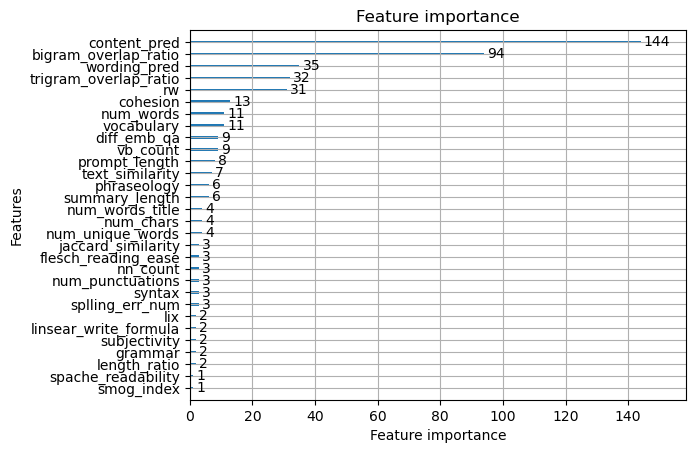

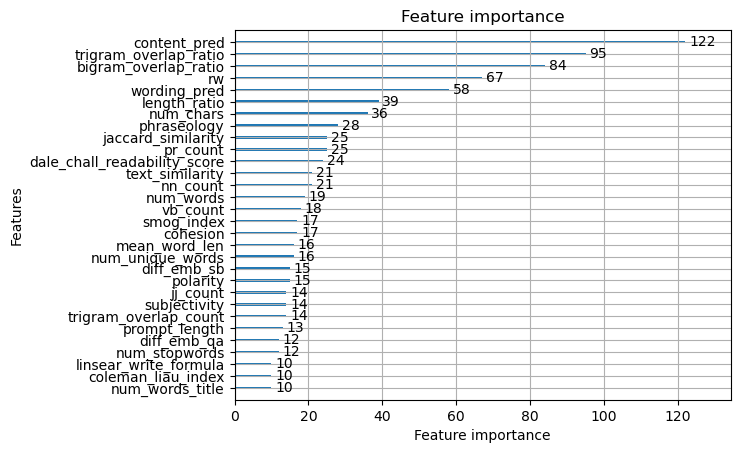

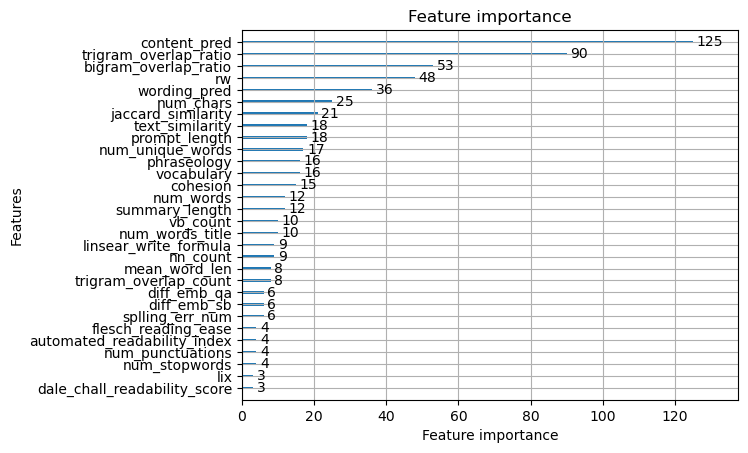

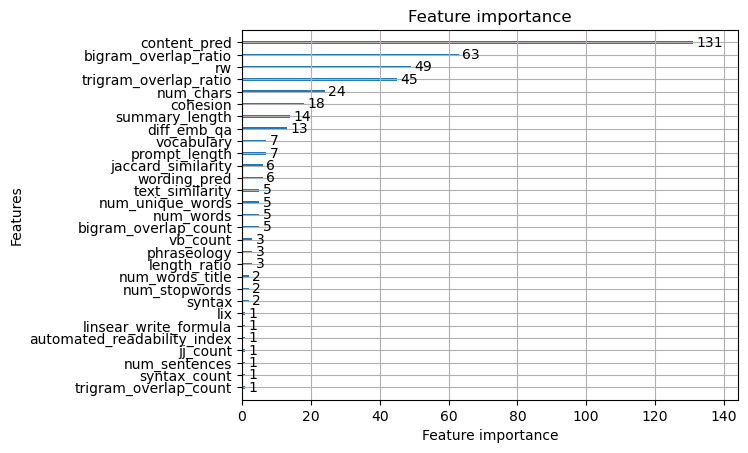

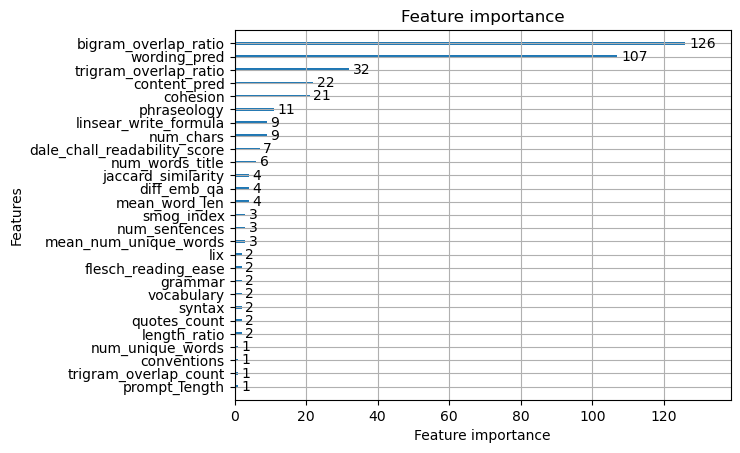

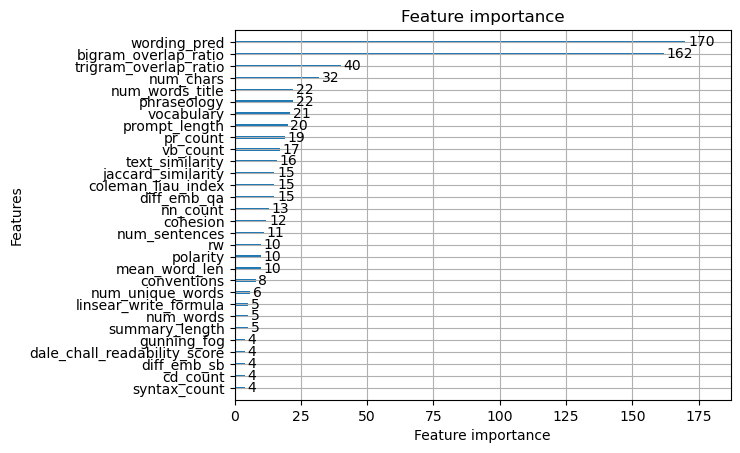

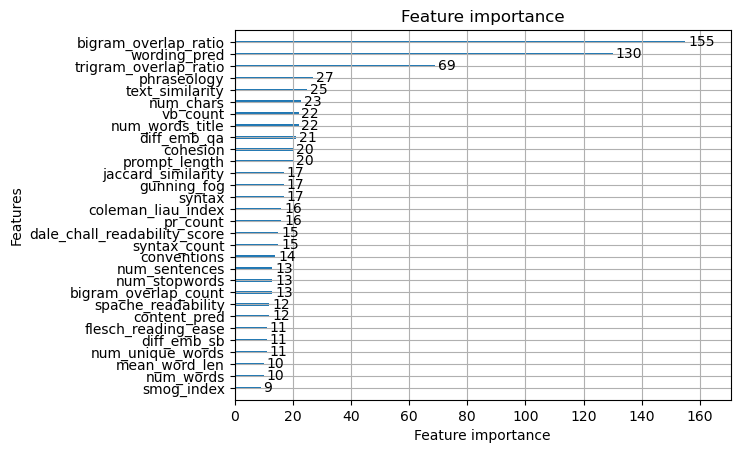

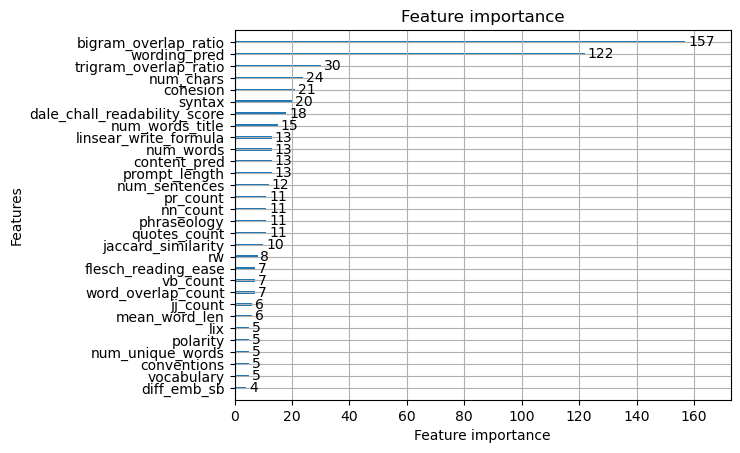

In [59]:
model_dict = {}

for target in targets:
    models = []
    
    for fold in range(CFG.n_splits):

        X_train_cv = train[train["fold"] != fold][features]
        y_train_cv = train[train["fold"] != fold][target]

        X_eval_cv = train[train["fold"] == fold][features]
        y_eval_cv = train[train["fold"] == fold][target]

        dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
        dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)
        params = {
            'boosting_type': 'gbdt',
            'random_state': 42,
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.048,
            'max_depth': 3, 
            'lambda_l1': 0.0,
            'lambda_l2': 0.011
        }

        evaluation_results = {}
        model = lgb.train(params,
                          num_boost_round=10000,
                            #categorical_feature = categorical_features,
                          valid_names=['train', 'valid'],
                          train_set=dtrain,
                          valid_sets=dval,
                          callbacks=[
                              lgb.early_stopping(stopping_rounds=30, verbose=True),
                               lgb.log_evaluation(100),
                              lgb.callback.record_evaluation(evaluation_results)
                            ],
                          )
        print(lgb.plot_importance(model,max_num_features=30))
        models.append(model)
    model_dict[target] = models

In [60]:
# cv
rmses = []

for target in targets:
    models = model_dict[target]

    preds = []
    trues = []
    
    for fold, model in enumerate(models):
        X_eval_cv = train[train["fold"] == fold][features]
        y_eval_cv = train[train["fold"] == fold][target]

        pred = model.predict(X_eval_cv)

        trues.extend(y_eval_cv)
        preds.extend(pred)
        
    rmse = np.sqrt(mean_squared_error(trues, preds))
    print(f"{target}_rmse : {rmse}")
    rmses = rmses + [rmse]

print(f"mcrmse : {sum(rmses) / len(rmses)}")

content_rmse : 0.4498979708654662
wording_rmse : 0.5651296207026596
mcrmse : 0.5075137957840629


In [61]:
test['ch']=test['ch'].astype(float)

In [62]:
pred_dict = {}
for target in targets:
    models = model_dict[target]
    preds = []

    for fold, model in enumerate(models):
        X_eval_cv = test[features]

        pred = model.predict(X_eval_cv)
        preds.append(pred)
    
    pred_dict[target] = preds

In [63]:
for target in targets:
    preds = pred_dict[target]
    for i, pred in enumerate(preds):
        test[f"{target}_pred_{i}"] = pred

    test[target] = test[[f"{target}_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)

In [64]:
test[["student_id", "content", "wording"]].to_csv("submission.csv", index=False)